# Gesture Recognition
In this project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Import libraries to get started.

In [87]:
import numpy as np
import datetime
import os
import cv2

import random as rn
import tensorflow as tf
from keras import backend as K

In [88]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization
from keras.layers import Activation, Dropout, ZeroPadding3D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from tensorflow.keras.layers import LSTM, GRU


We set the random seed so that the results don't vary drastically.

In [89]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

train_path = './Project_data/train'
val_path = './Project_data/val'
train_doc = np.random.permutation(open(f'Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(f'Project_data/val.csv').readlines())

## Generator Class
This is one of the most important part of the code. The overall structure of the generator is broken down into modules. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. 

In [90]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) 

In [91]:
from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

Let's test the function resize_crop_image by writing a test function

In [92]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))
            
        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')
        
        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')
                
    plt.show()

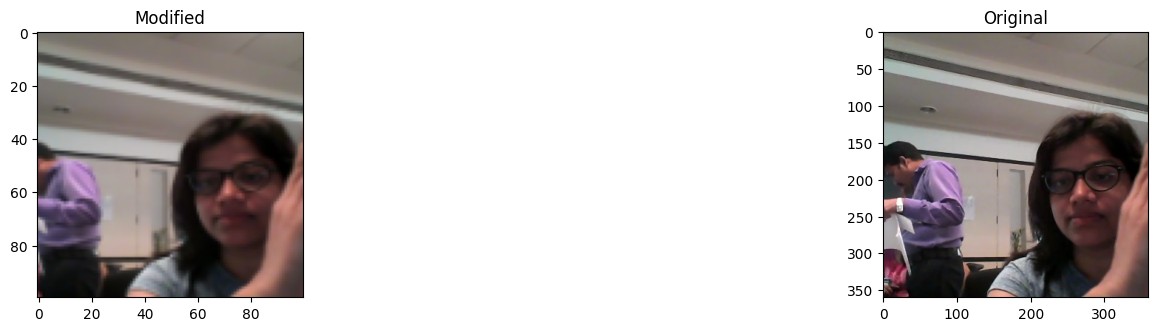

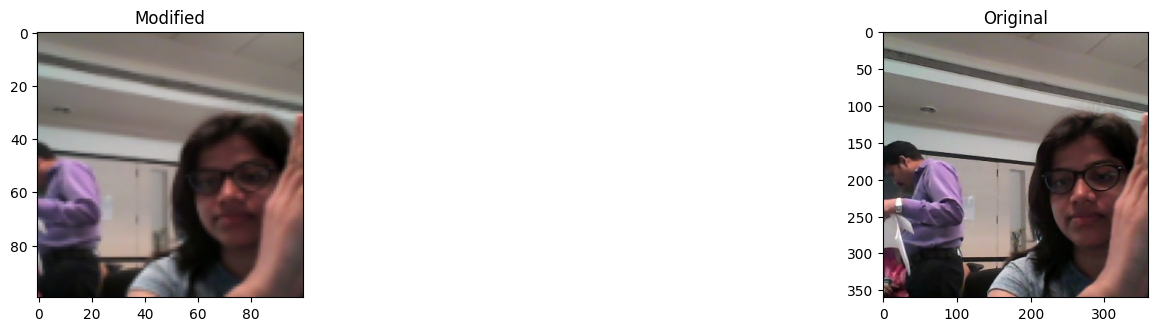

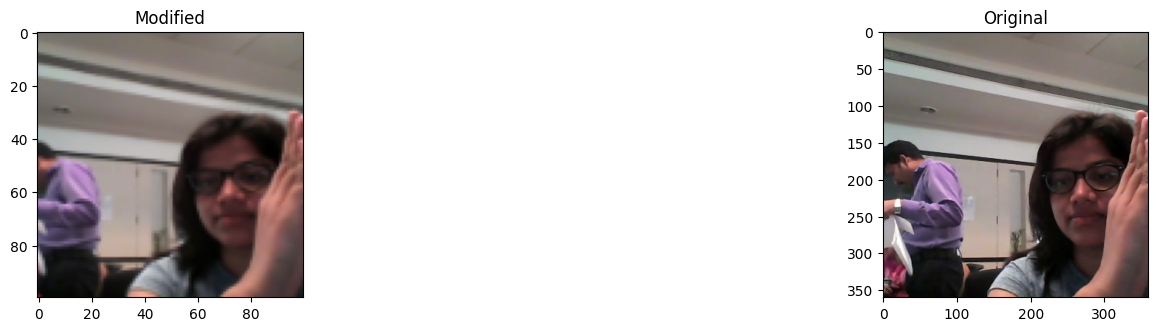

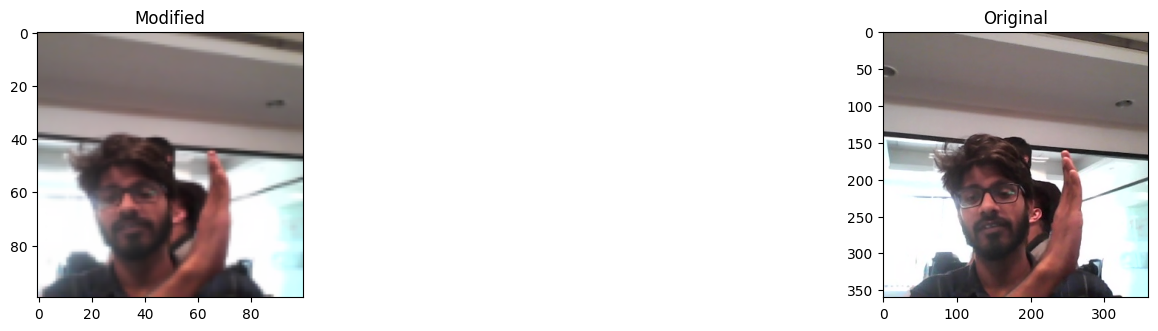

In [93]:
paths = ["Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png",
        "Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00014.png",
        "Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00018.png",
        "Project_data/train/WIN_20180907_15_43_28_Pro_Right Swipe_new/WIN_20180907_15_43_28_Pro_00013.png"]

show_resize_crop_image(paths)

In [94]:
class DataGenerator:
    def __init__(self, width=120, height=120, frames=30, channel=3, 
                 crop = True, normalize = False, affine = False, flip = False, edge = False  ):
        self.width = width   # X dimension of the image
        self.height = height # Y dimesnion of the image
        self.frames = frames # length/depth of the video frames
        self.channel = channel # number of channels in images 3 for color(RGB) and 1 for Gray  
        self.affine = affine # augment data with affine transform of the image
        self.flip = flip
        self.normalize =  normalize
        self.edge = edge # edge detection
        self.crop = crop

    # Helper function to generate a random affine transform on the image
    def __get_random_affine(self): # private method
        dx, dy = np.random.randint(-1.7, 1.8, 2)
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        return M

    # Helper function to initialize all the batch image data and labels
    def __init_batch_data(self, batch_size): # private method
        batch_data = np.zeros((batch_size, self.frames, self.width, self.height, self.channel)) 
        batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
        return batch_data, batch_labels

    def __load_batch_images(self, source_path, folder_list, batch_num, batch_size, t): # private method
    
        batch_data,batch_labels = self.__init_batch_data(batch_size)
        # We will also build a agumented batch data
        if self.affine:
            batch_data_aug,batch_labels_aug = self.__init_batch_data(batch_size)
        if self.flip:
            batch_data_flip,batch_labels_flip = self.__init_batch_data(batch_size)

        #create a list of image numbers you want to use for a particular video
        img_idx = [x for x in range(0, self.frames)] 

        for folder in range(batch_size): # iterate over the batch_size
            # read all the images in the folder
            imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
            # Generate a random affine to be used in image transformation for buidling agumented data set
            M = self.__get_random_affine()
            
            #  Iterate over the frames/images of a folder to read them in
            for idx, item in enumerate(img_idx): 
                image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes  
                if self.crop:
                    image = self.__crop(image)
                # If normalize is set normalize the image else use the raw image.
                if self.normalize:
                    resized = self.__normalize(self.__resize(image))
                else:
                    resized = self.__resize(image)
                # If the input is edge detected image then use the sobelx, sobely and laplacian as 3 channel of the edge detected image
                if self.edge:
                    resized = self.__edge(resized)
                
                batch_data[folder,idx] = resized
                if self.affine:
                    batch_data_aug[folder,idx] = self.__affine(resized, M)   
                if self.flip:
                    batch_data_flip[folder,idx] = self.__flip(resized)   

            batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
            
            if self.affine:
                batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
            
            if self.flip:
                if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
                elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                else:
                    batch_labels_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        if self.affine:
            batch_data = np.append(batch_data, batch_data_aug, axis = 0) 
            batch_labels = np.append(batch_labels, batch_labels_aug, axis = 0) 
        if self.flip:
            batch_data = np.append(batch_data, batch_data_flip, axis = 0) 
            batch_labels = np.append(batch_labels, batch_labels_flip, axis = 0) 

        return batch_data, batch_labels
    
    def generator(self, source_path, folder_list, batch_size): # public method
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(folder_list)//batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                # you yield the batch_data and the batch_labels, remember what does yield do
                yield self.__load_batch_images(source_path, folder_list, batch, batch_size, t) 
            
            # Code for the remaining data points which are left after full batches
            if (len(folder_list) != batch_size*num_batches):
                batch_size = len(folder_list) - (batch_size*num_batches)
                yield self.__load_batch_images(source_path, folder_list, num_batches, batch_size, t)

    # Helper function to perfom affice transform on the image
    def __affine(self, image, M):
        return cv2.warpAffine(image, M, (image.shape[0], image.shape[1]))

    # Helper function to flip the image
    def __flip(self, image):
        return np.flip(image,1)
    
    # Helper function to normalise the data
    def __normalize(self, image):
        return image/127.5-1
    
    # Helper function to resize the image
    def __resize(self, image):
        return cv2.resize(image, (self.width,self.height), interpolation = cv2.INTER_AREA)
    
    # Helper function to crop the image
    def __crop(self, image):
        if image.shape[0] != image.shape[1]:
            return image[0:120, 20:140]
        else:
            return image

    # Helper function for edge detection
    def __edge(self, image):
        edge = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
        edge[:,:,0] = cv2.Laplacian(cv2.GaussianBlur(image[:,:,0],(3,3),0),cv2.CV_64F)
        edge[:,:,1] = cv2.Laplacian(cv2.GaussianBlur(image[:,:,1],(3,3),0),cv2.CV_64F)
        edge[:,:,2] = cv2.Laplacian(cv2.GaussianBlur(image[:,:,2],(3,3),0),cv2.CV_64F)
        return edge

## Model Class
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [95]:
class ModelGenerator(object):
    
    @classmethod
    def c3d1(cls, input_shape, nb_classes):
      
        # Model.
        model = Sequential()
        model.add(Conv3D(
            8, (3,3,3), activation='relu', input_shape=input_shape
        ))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        model.add(Conv3D(16, (3,3,3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        model.add(Conv3D(32, (3,3,3), activation='relu'))
        model.add(Conv3D(32, (3,3,3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        model.add(Conv3D(64, (2,2,2), activation='relu'))
        model.add(Conv3D(64, (2,2,2), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(Dropout(0.5))
        model.add(Dense(256))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes, activation='softmax'))

        return model
    
    @classmethod
    def c3d2(cls, input_shape, nb_classes):
           
        model = Sequential()
        
        # 1st layer group
        model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same', name='conv1', strides=(1, 1, 1), input_shape=input_shape))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1'))
     
        # 2nd layer group
        model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', name='conv2'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'))
        
        # 3rd layer group
        model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv3a', strides=(1, 1, 1)))
        model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv3b', strides=(1, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'))
        
        # 4th layer group
        model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv4a', strides=(1, 1, 1)))
        model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv4b', strides=(1, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'))

        # 5th layer group
        model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv5a', strides=(1, 1, 1)))
        model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv5b', strides=(1, 1, 1)))
        model.add(ZeroPadding3D(padding=(0, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'))
        
        # Flatten and fully connected layers
        model.add(Flatten())
        model.add(Dense(512, activation='relu', name='fc6'))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu', name='fc7'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes, activation='softmax', name='fc8'))

        return model
    
    @classmethod
    def c3d3(cls, input_shape, nb_classes):
        model = Sequential()
        model.add(Conv3D(16, kernel_size=(3, 3, 3), input_shape=input_shape, padding='same'))
        model.add(Activation('relu'))
        model.add(Conv3D(16, padding="same", kernel_size=(3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
        model.add(Dropout(0.25))

        model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
        model.add(Activation('relu'))
        model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
        model.add(Dropout(0.25))

        model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
        model.add(Activation('relu'))
        model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes, activation='softmax'))

        return model
 
    @classmethod
    def c3d4(cls, input_shape, nb_classes):
        # Define model conv3d model
        model = Sequential()

        model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))

        model.add(MaxPooling3D(pool_size=(2,2,2)))

        #Flatten Layers
        model.add(Flatten())

        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))

        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))

        #softmax layer
        model.add(Dense(5, activation='softmax'))
        return model
    
    @classmethod
    def c3d5(cls, input_shape, nb_classes):
        # Define model MaxPooling3D
        model = Sequential()

        model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
        #model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))

        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
        #model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))

        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
        #model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))

        model.add(MaxPooling3D(pool_size=(2,2,2)))

        model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
        model.add(Activation('relu'))
        model.add(Dropout(0.25))

        model.add(MaxPooling3D(pool_size=(2,2,2)))

        #Flatten Layers
        model.add(Flatten())

        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))

        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))

        #softmax layer
        model.add(Dense(5, activation='softmax'))
        return model   
    
    @classmethod
    def lstm(cls, input_shape, nb_classes):
        """Build a simple LSTM network. We pass the extracted features from
        our CNN to this model predomenently."""
        # Model.
        model = Sequential()
        model.add(LSTM(2048, return_sequences=False,
                       input_shape=input_shape,
                       dropout=0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes, activation='softmax'))

        return model

    @classmethod
    def lrcn(cls, input_shape, nb_classes):
        """Build a CNN into RNN.
        
        """
        model = Sequential()

        model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
            activation='relu', padding='same'), input_shape=input_shape))
        model.add(TimeDistributed(Conv2D(32, (3,3),
            kernel_initializer="he_normal", activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(64, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(128, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(256, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        
        model.add(TimeDistributed(Conv2D(512, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(0.5))
        model.add(LSTM(256, return_sequences=False, dropout=0.5))
        model.add(Dense(nb_classes, activation='softmax'))

        return model

    @classmethod
    def mlp(cls, input_shape, nb_classes):
        """Build a simple MLP. It uses extracted features as the input
        because of the otherwise too-high dimensionality."""
        # Model.
        model = Sequential()
        model.add(Flatten(input_shape=input_shape))
        model.add(Dense(512))
        model.add(Dropout(0.5))
        model.add(Dense(512))
        model.add(Dropout(0.5))
        model.add(Dense(nb_classes, activation='softmax'))

        return model

## Trainer Function

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [96]:
def train(batch_size, num_epochs, model, train_generator, val_generator, optimiser=None):

    curr_dt_time = datetime.datetime.now()

    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print('# batch size =', batch_size)    
    print('# epochs =', num_epochs)

    #optimizer = Adam(lr=rate) 
    #write your optimizer
    if optimiser == None:
        optimiser = Adam() 
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

    checkpoint = ModelCheckpoint(
                    filepath,
                    monitor='val_loss',
                    verbose=1,
                    save_best_only=False,
                    save_weights_only=False,
                    mode='auto',
                    save_freq='epoch'  # Save the model after every epoch
                )

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
    callbacks_list = [checkpoint, LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            verbose=1,
            callbacks=callbacks_list,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=None,
            initial_epoch=0
        )
    
    K.clear_session()

In [98]:
from numba import cuda
def clear_cuda():
    #cuda.select_device(0)
    #cuda.close()
    pass

In [100]:
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPooling3D, Flatten, BatchNormalization, Activation, Dropout, Input

# Define the model
model = Sequential()

# Add an explicit Input layer
model.add(Input(shape=(18, 100, 100, 3)))

# Layer 1: Conv3D and MaxPooling3D
model.add(Conv3D(16, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Layer 2: Conv3D and MaxPooling3D
model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Layer 3: Conv3D and MaxPooling3D
model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Layer 4: Conv3D and MaxPooling3D
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output for the Dense layers
model.add(Flatten())

# Layer 5: Dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# Layer 6: Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

# Output layer: Softmax for classification
model.add(Dense(5, activation='softmax'))  # 5 output classes


## Model #1

### Model 1a : Resize to 120*120,  Raw image input, No cropping, No normalisation, No agumentation, No flipped images, No edge detection

In [37]:
train_gen = DataGenerator()
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d1(input_shape, num_classes)

batch_size = 20
num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)


# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 20


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_24 (Conv3D)              │ (None, 28, 118, 118,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 28, 59, 59, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_25 (Conv3D)              │ (None, 26, 57, 57, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_17 (MaxPooling3D) │ (None, 26, 28, 28, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_26 (Conv3D)              │ (None, 24, 26, 26, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_27 (Conv3D)              │ (None, 22, 24, 24, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 22, 12, 12, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_28 (Conv3D)              │ (None, 21, 11, 11, 64) │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_29 (Conv3D)              │ (None, 20, 10, 10, 64) │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 20, 5, 5, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    16,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,612,069 (63.37 MB)

 Trainable params: 16,612,069 (63.37 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2220 - loss: 152.6553Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-12-0315_24_36.847904/model-00001-56.67712-0.23831-1.61875-0.14000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - categorical_accuracy: 0.2225 - loss: 149.9130 - val_categorical_accuracy: 0.1400 - val_loss: 1.6187 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - categorical_accuracy: 0.2096 - loss: 1.6146
Epoch 2: saving model to model_init_2024-12-0315_24_36.847904/model-00002-1.61663-0.21569-1.66293-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - categorical_accuracy: 0.2098 - loss: 1.6146 - val_categorical_accuracy: 0.2300 - val_loss: 1.6629 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - categorical_accuracy: 0.2525 - loss: 1.6310
Epoch 3: saving model to model_init_2024-1

### Model 1b : Resize to 120*120, agumentation, No flipped images, No cropping, No normalisation, No edge detection

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

train_gen = DataGenerator(affine=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d1(input_shape, num_classes)

#batch_size = 20
num_epochs = 10

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 28, 118, 118,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 28, 59, 59, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 26, 57, 57, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 26, 28, 28, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 24, 26, 26, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 22, 24, 24, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 22, 12, 12, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 21, 11, 11, 64) │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 20, 10, 10, 64) │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 5, 5, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,612,069 (63.37 MB)

 Trainable params: 16,612,069 (63.37 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.1973 - loss: 26.4666 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-12-0315_38_27.202161/model-00001-10.67341-0.19834-1.60645-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 369s 11s/step - categorical_accuracy: 0.1973 - loss: 26.0153 - val_categorical_accuracy: 0.2300 - val_loss: 1.6064 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2366 - loss: 1.6054
Epoch 2: saving model to model_init_2024-12-0315_38_27.202161/model-00002-1.59244-0.28922-1.62187-0.18000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.2381 - loss: 1.6050 - val_categorical_accuracy: 0.1800 - val_loss: 1.6219 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2225 - loss: 1.6257
Epoch 3: saving model to model_init_2024-12-031

### Model 1c : Resize to 120*120, agumentation, flipped images, No normalisation, No cropping, No edge detection

In [39]:
train_gen = DataGenerator(affine=True, flip=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d1(input_shape, num_classes)

#batch_size = 20
num_epochs = 10

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 28, 118, 118,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 28, 59, 59, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 26, 57, 57, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 26, 28, 28, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 24, 26, 26, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 22, 24, 24, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 22, 12, 12, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 21, 11, 11, 64) │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 20, 10, 10, 64) │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 5, 5, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,612,069 (63.37 MB)

 Trainable params: 16,612,069 (63.37 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - categorical_accuracy: 0.2164 - loss: 66.3786 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-12-0315_55_00.867354/model-00001-24.44917-0.23580-1.49945-0.26000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 508s 15s/step - categorical_accuracy: 0.2170 - loss: 65.1806 - val_categorical_accuracy: 0.2600 - val_loss: 1.4995 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3139 - loss: 1.4591
Epoch 2: saving model to model_init_2024-12-0315_55_00.867354/model-00002-1.41663-0.35294-1.44316-0.38000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.3150 - loss: 1.4579 - val_categorical_accuracy: 0.3800 - val_loss: 1.4432 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4632 - loss: 1.2832
Epoch 3: saving model to model_init_2024-12-031

### Model 1d : Resize to 120*120,  agumentation, flipped images, normalisation, No cropping, No edge detection

In [40]:
train_gen = DataGenerator(affine=True, flip=True, normalize=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d1(input_shape, num_classes)

#batch_size = 20
num_epochs = 10

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 28, 118, 118,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 28, 59, 59, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 26, 57, 57, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 26, 28, 28, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 24, 26, 26, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 22, 24, 24, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 22, 12, 12, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 21, 11, 11, 64) │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 20, 10, 10, 64) │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 5, 5, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,612,069 (63.37 MB)

 Trainable params: 16,612,069 (63.37 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - categorical_accuracy: 0.2417 - loss: 1.6967 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-12-0316_15_43.172628/model-00001-1.58480-0.28658-317.43524-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 432s 13s/step - categorical_accuracy: 0.2430 - loss: 1.6935 - val_categorical_accuracy: 0.2300 - val_loss: 317.4352 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2658 - loss: 1.4741
Epoch 2: saving model to model_init_2024-12-0316_15_43.172628/model-00002-1.58474-0.25163-115.15537-0.20000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0.2654 - loss: 1.4773 - val_categorical_accuracy: 0.2000 - val_loss: 115.1554 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.1560 - loss: 1.6650
Epoch 3: saving model to model_init_2024-1

### Model 1e : Resize to 120*120,  agumentation, flipped images, normalisation, cropping, No edge detection

In [41]:
train_gen = DataGenerator(affine=True, flip=True, normalize=True, crop=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d1(input_shape, num_classes)

#batch_size = 20
num_epochs = 10

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 28, 118, 118,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 28, 59, 59, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 26, 57, 57, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 26, 28, 28, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 24, 26, 26, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 22, 24, 24, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 22, 12, 12, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 21, 11, 11, 64) │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 20, 10, 10, 64) │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 5, 5, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,612,069 (63.37 MB)

 Trainable params: 16,612,069 (63.37 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - categorical_accuracy: 0.2062 - loss: 2.5184 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-12-0316_33_15.039225/model-00001-1.93483-0.19457-3.47630-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 441s 13s/step - categorical_accuracy: 0.2059 - loss: 2.5017 - val_categorical_accuracy: 0.2100 - val_loss: 3.4763 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3562 - loss: 1.5961
Epoch 2: saving model to model_init_2024-12-0316_33_15.039225/model-00002-1.61539-0.23529-3.42137-0.19000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.3528 - loss: 1.5967 - val_categorical_accuracy: 0.1900 - val_loss: 3.4214 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3112 - loss: 1.5962
Epoch 3: saving model to model_init_2024-12-0316_3

### Model 1f : Resize to 120*120,  agumentation, flipped images, normalisation, cropping, edge detection

In [42]:
train_gen = DataGenerator(affine=True, flip=True, normalize=True, crop=True, edge=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d1(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 28, 118, 118,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 28, 59, 59, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 26, 57, 57, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 26, 28, 28, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 24, 26, 26, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 22, 24, 24, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 22, 12, 12, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 21, 11, 11, 64) │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 20, 10, 10, 64) │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 5, 5, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,612,069 (63.37 MB)

 Trainable params: 16,612,069 (63.37 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - categorical_accuracy: 0.2236 - loss: 2.0076 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-12-0316_51_05.581160/model-00001-1.71804-0.24183-527.62549-0.22000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1301s 39s/step - categorical_accuracy: 0.2241 - loss: 1.9993 - val_categorical_accuracy: 0.2200 - val_loss: 527.6255 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2220 - loss: 1.6148
Epoch 2: saving model to model_init_2024-12-0316_51_05.581160/model-00002-1.65569-0.21242-4.53692-0.28000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - categorical_accuracy: 0.2217 - loss: 1.6160 - val_categorical_accuracy: 0.2800 - val_loss: 4.5369 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.1247 - loss: 1.6410
Epoch 3: saving model to model_init_2024-12-0

## Model #2

### Model 2a : Resize to 120*120,  No agumentation, No flipped images, No normalisation, No cropping, No edge detection

In [50]:
train_gen = DataGenerator()
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d2(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 10


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv3D)                  │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling3D)            │ (None, 30, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv3D)                  │ (None, 30, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling3D)            │ (None, 15, 30, 30, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3a (Conv3D)                 │ (None, 15, 30, 30, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3b (Conv3D)                 │ (None, 15, 30, 30, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling3D)            │ (None, 7, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4a (Conv3D)                 │ (None, 7, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4b (Conv3D)                 │ (None, 7, 15, 15, 128) │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling3D)            │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5a (Conv3D)                 │ (None, 3, 7, 7, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5b (Conv3D)                 │ (None, 3, 7, 7, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding3d (ZeroPadding3D)  │ (None, 3, 9, 9, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling3D)            │ (None, 1, 4, 4, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6 (Dense)                     │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc7 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc8 (Dense)                     │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,862,597 (22.36 MB)

 Trainable params: 5,862,597 (22.36 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.2104 - loss: 3.5318 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-12-0320_06_07.422536/model-00001-2.21507-0.19457-1.60737-0.22000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 344s 10s/step - categorical_accuracy: 0.2099 - loss: 3.4942 - val_categorical_accuracy: 0.2200 - val_loss: 1.6074 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.1341 - loss: 1.6135
Epoch 2: saving model to model_init_2024-12-0320_06_07.422536/model-00002-1.61110-0.15686-1.61122-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - categorical_accuracy: 0.1347 - loss: 1.6134 - val_categorical_accuracy: 0.2100 - val_loss: 1.6112 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.1289 - loss: 1.6145
Epoch 3: saving model to model_init_2024-12-0320_0

### Model 2b : Resize to 120*120, agumentation, No flipped images, No normalisation, No cropping, No edge detection

In [51]:
train_gen = DataGenerator(affine=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d2(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv3D)                  │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling3D)            │ (None, 30, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv3D)                  │ (None, 30, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling3D)            │ (None, 15, 30, 30, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3a (Conv3D)                 │ (None, 15, 30, 30, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3b (Conv3D)                 │ (None, 15, 30, 30, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling3D)            │ (None, 7, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4a (Conv3D)                 │ (None, 7, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4b (Conv3D)                 │ (None, 7, 15, 15, 128) │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling3D)            │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5a (Conv3D)                 │ (None, 3, 7, 7, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5b (Conv3D)                 │ (None, 3, 7, 7, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding3d (ZeroPadding3D)  │ (None, 3, 9, 9, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling3D)            │ (None, 1, 4, 4, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6 (Dense)                     │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc7 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc8 (Dense)                     │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,862,597 (22.36 MB)

 Trainable params: 5,862,597 (22.36 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - categorical_accuracy: 0.2002 - loss: 3.8253 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-12-0320_27_00.955434/model-00001-2.26903-0.19759-1.60076-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 886s 26s/step - categorical_accuracy: 0.2001 - loss: 3.7808 - val_categorical_accuracy: 0.2300 - val_loss: 1.6008 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3103 - loss: 1.6624
Epoch 2: saving model to model_init_2024-12-0320_27_00.955434/model-00002-1.65433-0.29412-1.60476-0.19000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - categorical_accuracy: 0.3098 - loss: 1.6621 - val_categorical_accuracy: 0.1900 - val_loss: 1.6048 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.1833 - loss: 1.5712
Epoch 3: saving model to model_init_2024-12-0320_

### Model 2c : Resize to 120*120, agumentation, flipped images, No normalisation, No cropping, No edge detection

In [52]:
train_gen = DataGenerator(affine=True, flip=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d2(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv3D)                  │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling3D)            │ (None, 30, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv3D)                  │ (None, 30, 60, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling3D)            │ (None, 15, 30, 30, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3a (Conv3D)                 │ (None, 15, 30, 30, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3b (Conv3D)                 │ (None, 15, 30, 30, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling3D)            │ (None, 7, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4a (Conv3D)                 │ (None, 7, 15, 15, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4b (Conv3D)                 │ (None, 7, 15, 15, 128) │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling3D)            │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5a (Conv3D)                 │ (None, 3, 7, 7, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5b (Conv3D)                 │ (None, 3, 7, 7, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding3d (ZeroPadding3D)  │ (None, 3, 9, 9, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling3D)            │ (None, 1, 4, 4, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6 (Dense)                     │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc7 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc8 (Dense)                     │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,862,597 (22.36 MB)

 Trainable params: 5,862,597 (22.36 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - categorical_accuracy: 0.2202 - loss: 5.1075 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-12-0321_00_08.455821/model-00001-2.74377-0.20965-1.55721-0.27000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1163s 34s/step - categorical_accuracy: 0.2199 - loss: 5.0400 - val_categorical_accuracy: 0.2700 - val_loss: 1.5572 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.1535 - loss: 1.6282
Epoch 2: saving model to model_init_2024-12-0321_00_08.455821/model-00002-1.61932-0.19608-1.60698-0.22000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step - categorical_accuracy: 0.1548 - loss: 1.6279 - val_categorical_accuracy: 0.2200 - val_loss: 1.6070 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.1468 - loss: 1.6171
Epoch 3: saving model to model_init_2024-12-0321

### Model 2d : Resize to 120*120, agumentation, flipped images, normalisation, No cropping, No edge detection

In [ ]:
train_gen = DataGenerator(affine=True, flip=True, normalize=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d2(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)


## Model #3

### Model 3a : Resize to 120*120,  No agumentation, No flipped images, No normalisation, No cropping, No edge detection

In [54]:
train_gen = DataGenerator()
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d3(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 20
# epochs = 10


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 30, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 40, 40, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 40, 40, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 10, 40, 40, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 40, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 10, 40, 40, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10, 40, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 4, 14, 14, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 4, 14, 14, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 5, 5, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 5, 5, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 929,461 (3.55 MB)

 Trainable params: 928,437 (3.54 MB)

 Non-trainable params: 1,024 (4.00 KB)

None
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2296 - loss: 2.3232Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-12-0323_24_27.642886/model-00001-2.12063-0.27753-26.14662-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 300s 9s/step - categorical_accuracy: 0.2310 - loss: 2.3174 - val_categorical_accuracy: 0.2300 - val_loss: 26.1466 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3415 - loss: 1.7443
Epoch 2: saving model to model_init_2024-12-0323_24_27.642886/model-00002-1.76502-0.34314-12.20412-0.18000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - categorical_accuracy: 0.3415 - loss: 1.7449 - val_categorical_accuracy: 0.1800 - val_loss: 12.2041 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2901 - loss: 2.0317
Epoch 3: saving model to model_init_2024-12-0323_

### Model 3b : Resize to 120*120,   agumentation, No flipped images, No normalisation, No cropping, No edge detection

In [63]:
train_gen = DataGenerator(affine=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d3(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 90
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 30, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 40, 40, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 40, 40, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 10, 40, 40, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 40, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 10, 40, 40, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10, 40, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 4, 14, 14, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 4, 14, 14, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 5, 5, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 5, 5, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 929,461 (3.55 MB)

 Trainable params: 928,437 (3.54 MB)

 Non-trainable params: 1,024 (4.00 KB)

None
Source path =  ./Project_data/train ; batch size = 90
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 201s/step - categorical_accuracy: 0.2765 - loss: 2.2717  Source path =  ./Project_data/val ; batch size = 90

Epoch 1: saving model to model_init_2024-12-0411_36_04.300834/model-00001-2.16140-0.30392-40.46215-0.23000.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1678s 204s/step - categorical_accuracy: 0.2796 - loss: 2.2595 - val_categorical_accuracy: 0.2300 - val_loss: 40.4622 - learning_rate: 0.0010
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - categorical_accuracy: 0.4101 - loss: 1.7454 
Epoch 2: saving model to model_init_2024-12-0411_36_04.300834/model-00002-1.73878-0.40152-32.46897-0.20000.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 309s 38s/step - categorical_accuracy: 0.4091 - loss: 1.7447 - val_categorical_accuracy: 0.2000 - val_loss: 32.4690 - learning_rate: 0.0010
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - categorical_accuracy: 0.3669 - loss: 1.7647 
Epoch 3: saving model to model_init_2024-12-04

### Model 3c : Resize to 120*120,  agumentation, flipped images, No normalisation, No cropping, No edge detection

In [62]:
train_gen = DataGenerator(affine=True, flip=True, normalize=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d3(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 90
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 30, 120, 120,   │         6,928 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 40, 40, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 40, 40, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 10, 40, 40, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 40, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 10, 40, 40, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10, 40, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 4, 14, 14, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 4, 14, 14, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 14, 14, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 5, 5, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 5, 5, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 929,461 (3.55 MB)

 Trainable params: 928,437 (3.54 MB)

 Non-trainable params: 1,024 (4.00 KB)

None
Source path =  ./Project_data/train ; batch size = 90
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 327s/step - categorical_accuracy: 0.2654 - loss: 2.0997  Source path =  ./Project_data/val ; batch size = 90

Epoch 1: saving model to model_init_2024-12-0410_18_08.736941/model-00001-1.86909-0.30769-83.69973-0.25000.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 2696s 329s/step - categorical_accuracy: 0.2701 - loss: 2.0741 - val_categorical_accuracy: 0.2500 - val_loss: 83.6997 - learning_rate: 0.0010
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 112s/step - categorical_accuracy: 0.3693 - loss: 1.4677  
Epoch 2: saving model to model_init_2024-12-0410_18_08.736941/model-00002-1.44017-0.38636-27.45049-0.20000.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 841s 112s/step - categorical_accuracy: 0.3712 - loss: 1.4646 - val_categorical_accuracy: 0.2000 - val_loss: 27.4505 - learning_rate: 0.0010
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 74s/step - categorical_accuracy: 0.4785 - loss: 1.1126  
Epoch 3: saving model to model_init_2024-1

## Model #4

### Model 4a : Resize to 120*120,  No agumentation, No flipped images, No normalisation, No cropping, No edge detection

In [61]:
train_gen = DataGenerator()
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d4(input_shape, num_classes)

batch_size = 90
num_epochs = 10

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 90
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 60, 60, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 7, 30, 30, 32)  │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 15, 15, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 864,101 (3.30 MB)

 Trainable params: 863,989 (3.30 MB)

 Non-trainable params: 112 (448.00 B)

None
Source path =  ./Project_data/train ; batch size = 90
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - categorical_accuracy: 0.1950 - loss: 2.5291 Source path =  ./Project_data/val ; batch size = 90

Epoch 1: saving model to model_init_2024-12-0409_22_52.470522/model-00001-2.26780-0.20814-1.56939-0.25000.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 147s 18s/step - categorical_accuracy: 0.1965 - loss: 2.5000 - val_categorical_accuracy: 0.2500 - val_loss: 1.5694 - learning_rate: 0.0010
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 434s/step - categorical_accuracy: 0.2780 - loss: 1.5504  
Epoch 2: saving model to model_init_2024-12-0409_22_52.470522/model-00002-1.54475-0.29167-1.92837-0.20000.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3045s 434s/step - categorical_accuracy: 0.2795 - loss: 1.5498 - val_categorical_accuracy: 0.2000 - val_loss: 1.9284 - learning_rate: 0.0010
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.3488 - loss: 1.5160
Epoch 3: saving model to model_init_2024-12-0409_22_

### Model 4b : Resize to 120*120,  agumentation, No flipped images, No normalisation, No cropping, No edge detection

In [55]:
train_gen = DataGenerator(affine=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d4(input_shape, num_classes)

batch_size = 50
num_epochs = 10

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 50
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 60, 60, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 7, 30, 30, 32)  │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 15, 15, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 864,101 (3.30 MB)

 Trainable params: 863,989 (3.30 MB)

 Non-trainable params: 112 (448.00 B)

None
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - categorical_accuracy: 0.1984 - loss: 2.4609 Source path =  ./Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2024-12-0323_37_44.861324/model-00001-1.99988-0.22323-1.67662-0.18000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 291s 21s/step - categorical_accuracy: 0.2000 - loss: 2.4302 - val_categorical_accuracy: 0.1800 - val_loss: 1.6766 - learning_rate: 0.0010
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2922 - loss: 1.5227
Epoch 2: saving model to model_init_2024-12-0323_37_44.861324/model-00002-1.52424-0.29396-1.81105-0.18000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - categorical_accuracy: 0.2923 - loss: 1.5228 - val_categorical_accuracy: 0.1800 - val_loss: 1.8110 - learning_rate: 0.0010
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3483 - loss: 1.4541
Epoch 3: saving model to model_init_2024-12-0323_3

### Model 4c : Resize to 120*120,  agumentation,  flipped images, No normalisation, No cropping, No edge detection

In [56]:
train_gen = DataGenerator(affine=True, flip=True, normalize=True, crop=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d4(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 50
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 120, 120,   │            32 │
│ (BatchNormalization)            │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 60, 60, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 7, 30, 30, 32)  │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 30, 30, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 15, 15, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 864,101 (3.30 MB)

 Trainable params: 863,989 (3.30 MB)

 Non-trainable params: 112 (448.00 B)

None
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - categorical_accuracy: 0.2514 - loss: 2.2275 Source path =  ./Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2024-12-0323_59_45.930738/model-00001-1.87387-0.28959-16.37091-0.29000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 455s 32s/step - categorical_accuracy: 0.2539 - loss: 2.2039 - val_categorical_accuracy: 0.2900 - val_loss: 16.3709 - learning_rate: 0.0010
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.3787 - loss: 1.4874
Epoch 2: saving model to model_init_2024-12-0323_59_45.930738/model-00002-1.44446-0.37546-67.91635-0.34000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 110s 8s/step - categorical_accuracy: 0.3785 - loss: 1.4845 - val_categorical_accuracy: 0.3400 - val_loss: 67.9164 - learning_rate: 0.0010
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.4004 - loss: 1.4255
Epoch 3: saving model to model_init_2024-12-0

## Model #5

### Model 5a : Resize to 120*120,  No agumentation, No flipped images, No normalisation, No cropping, No edge detection

In [57]:
train_gen = DataGenerator()
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d5(input_shape, num_classes)

batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 50
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 7, 30, 30, 32)  │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 15, 15, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,877 (3.30 MB)

 Trainable params: 863,877 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.1967 - loss: 34.0064 Source path =  ./Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2024-12-0400_24_11.647163/model-00001-18.55767-0.18552-1.58346-0.21000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 158s 11s/step - categorical_accuracy: 0.1960 - loss: 32.9765 - val_categorical_accuracy: 0.2100 - val_loss: 1.5835 - learning_rate: 0.0010
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2235 - loss: 2.0211
Epoch 2: saving model to model_init_2024-12-0400_24_11.647163/model-00002-1.83362-0.21429-1.60110-0.17000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - categorical_accuracy: 0.2228 - loss: 2.0086 - val_categorical_accuracy: 0.1700 - val_loss: 1.6011 - learning_rate: 0.0010
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2404 - loss: 1.5888
Epoch 3: saving model to model_init_2024-12-040

### Model 5b : Resize to 120*120,  agumentation, No flipped images, No normalisation, No cropping, No edge detection

In [58]:
train_gen = DataGenerator(affine=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d5(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 50
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 7, 30, 30, 32)  │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 15, 15, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,877 (3.30 MB)

 Trainable params: 863,877 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - categorical_accuracy: 0.1767 - loss: 128.3439 Source path =  ./Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2024-12-0400_39_40.128015/model-00001-66.63148-0.19457-1.60596-0.28000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 449s 33s/step - categorical_accuracy: 0.1779 - loss: 124.2297 - val_categorical_accuracy: 0.2800 - val_loss: 1.6060 - learning_rate: 0.0010
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2583 - loss: 2.5003
Epoch 2: saving model to model_init_2024-12-0400_39_40.128015/model-00002-2.22200-0.26923-1.60335-0.26000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - categorical_accuracy: 0.2591 - loss: 2.4817 - val_categorical_accuracy: 0.2600 - val_loss: 1.6034 - learning_rate: 0.0010
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2112 - loss: 1.6359
Epoch 3: saving model to model_init_2024-12-0

### Model 5c : Resize to 120*120,  agumentation, flipped images, No normalisation, No cropping, No edge detection

In [59]:
train_gen = DataGenerator(affine=True, flip=True)
val_gen = DataGenerator()
model_gen = ModelGenerator()

input_shape = (30,120,120, 3)
num_classes = 5

model = model_gen.c3d5(input_shape, num_classes)

#batch_size = 20
#num_epochs = 20

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)
train(batch_size, num_epochs, model, train_generator, val_generator)

# training sequences = 663
# validation sequences = 100
# batch size = 50
# epochs = 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 120, 120,   │           656 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 120, 120,   │             0 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 60, 60, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 60, 60, 16) │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 60, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 30, 30, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 7, 30, 30, 32)  │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 30, 30, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 15, 15, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 15, 15, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,877 (3.30 MB)

 Trainable params: 863,877 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - categorical_accuracy: 0.1931 - loss: 75.0665 Source path =  ./Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2024-12-0400_57_51.873422/model-00001-38.77069-0.20161-1.58250-0.32000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 427s 30s/step - categorical_accuracy: 0.1936 - loss: 72.6468 - val_categorical_accuracy: 0.3200 - val_loss: 1.5825 - learning_rate: 0.0010
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2182 - loss: 1.9387
Epoch 2: saving model to model_init_2024-12-0400_57_51.873422/model-00002-1.79718-0.21245-1.60936-0.23000.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 113s 8s/step - categorical_accuracy: 0.2178 - loss: 1.9292 - val_categorical_accuracy: 0.2300 - val_loss: 1.6094 - learning_rate: 0.0010
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2105 - loss: 1.6598
Epoch 3: saving model to model_init_2024-12-04

In [66]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("model_init_2024-12-0411_36_04.300834/model-00010-1.96058-0.33333-9.46504-0.35000.keras")

# Save the model in HDF5 format
model.save("final.h5")


In [67]:
import h5py

# Open the HDF5 file
with h5py.File("final.h5", "r") as f:
    # List all groups in the HDF5 file
    print("Keys in the HDF5 file:")
    for key in f.keys():
        print(key)

    # Explore a specific group
    print("\nModel weights structure:")
    weights_group = f["model_weights"]
    for layer in weights_group.keys():
        print(layer)

    # Explore attributes
    print("\nAttributes of the root group:")
    for attr in f.attrs:
        print(f"{attr}: {f.attrs[attr]}")


Keys in the HDF5 file:
model_weights
optimizer_weights

Model weights structure:
activation
activation_1
activation_2
activation_3
activation_4
activation_5
batch_normalization
conv3d
conv3d_1
conv3d_2
conv3d_3
conv3d_4
conv3d_5
dense
dense_1
dropout
dropout_1
dropout_2
dropout_3
flatten
max_pooling3d
max_pooling3d_1
max_pooling3d_2
top_level_model_weights

Attributes of the root group:
backend: tensorflow
keras_version: 3.6.0
model_config: {"class_name": "Sequential", "config": {"name": "sequential", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "layers": [{"class_name": "InputLayer", "config": {"batch_shape": [null, 30, 120, 120, 3], "dtype": "float32", "sparse": false, "name": "input_layer"}}, {"class_name": "Conv3D", "config": {"name": "conv3d", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "filters": 16, "ke

In [72]:
history_model1 = model_gen.c3d5(input_shape, num_classes)


In [74]:
print("Total Params:", history_model1.count_params())
history_model1 = history_model1.train_model(conv_3d1_model)

Total Params: 863877


AttributeError: 'Sequential' object has no attribute 'train_model'

In [ ]:
plot(history_model1)